# Import Libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.losses import Loss
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Elastic Plane Strain Problem
In the perspective of elasticity theory, the deformation field in the body can be converted into a diminished 2d form if the forces and traction at the lateral boundaries are independently of the $z$ coordinate and have no $z$ component. This deformation is referred to as a state of plane strain in the $x,y$-plane.

$$u_x = u_x(x,y), \quad u_y = u_y(x,y), \quad u_z=0$$

The **strain–displacement equations** corresponding to plane strain problem become:

$$e_x=\frac{\partial u_x}{\partial x}, \quad e_y=\frac{\partial u_y}{\partial y}, \quad e_{xy}=\frac{1}{2}(\frac{\partial u_x}{\partial y} + \frac{\partial u_y}{\partial x})$$

$$e_{z} = e_{xz} = e_{yz} = 0$$

From the isotropic form of Hooke’s law, the allowable stresses reduce to:

$$\sigma_{x} = \lambda(e_x + e_y)+ 2\mu e_x$$

$$\sigma_{y} = \lambda(e_x + e_y)+ 2\mu e_y$$

$$\sigma_{z} = \lambda(e_x + e_y) = \nu(\sigma_{x} + \sigma_{y})$$

$$\tau_{xy} = 2\mu e_{xy}, \tau_{xz}=\tau_{yz}=0$$

The equilibrium equations for plane strain:

$$\frac{\partial \sigma_x}{\partial x} + \frac{\partial \tau_{xy}}{\partial y} + F_x = 0$$

$$\frac{\partial \tau_{xy}}{\partial x} + \frac{\partial \sigma_y}{\partial y} + F_y = 0$$

Plane Strain Coupled Navier Equations

$$\mu \nabla^{2}u_x + (\mu + \lambda) \frac{\partial}{\partial x}(\frac{\partial u_x}{\partial x} + \frac{\partial u_y}{\partial y}) + F_{x} = 0$$

$$\mu \nabla^{2}u_y + (\mu + \lambda) \frac{\partial}{\partial y}(\frac{\partial u_x}{\partial x} + \frac{\partial u_y}{\partial y}) + F_{y} = 0$$

**Problem Setup:**
<img src="Plane Strain Problem/photo/planeStrain.jpg" width="400">

We want to solve the plane strain coupled navier equations by using **physic informed neural network**. To illustrate the approach we consider an elastic plane-strain problem on the unit square subject to the boundary conditions depicted in the figure. The body forces are

$$F_x = \lambda[4\pi^{2}cos(2\pi x)sin(\pi y)-\pi cos(\pi x)Q y^{3}] + \mu [9\pi^2 cos(2\pi x)sin(\pi y) - \pi cos(\pi x)Qy^3]$$

$$F_y = \lambda[-3sin(\pi x)Qy^{2} + 2\pi^{2}sin(2\pi x)cos(\pi y)] + \mu[-6sin(\pi x)Qy^2 + 2\pi^2 sin(2\pi x)cos(\pi y)+\pi^2 sin(\pi x)Qy^4/4]$$

The boundary conditions:

$$u_x(x,y=0)=u_x(x,y=1)=u_y(x,y=0)=0$$

$$u_y(x=0,y)=u_y(x=1,y)=0$$

$$\sigma_x(x=0,y)=\sigma_x(x=1,y)=0$$

$$\sigma_y(x,y=1)=(\lambda + 2\mu)Qsin(\pi x)$$

The exact solution of this problem is

$$u_x(x,y) = cos(2\pi x)sin(\pi y)$$

$$u_y(x,y) = sin(\pi x)Qy^4/4$$


**Neural Network Setup**

The input features (variables) are the spatial coordinates $(x, y)$. For the outputs, a potential design is to have a densely connected network with two outputs as $(u_x, u_y)$. Another option is to have two densely connected independent networks with only one output each, associated with $u_x$ and $u_y$.

<img style="" src="photo/Networks.jpg" width=600>

we propose to have variables $u_x$, $u_y$ defined as independent ANNs as our architecture of choice

$$u_x(\mathbf{x}) \approx \mathcal{N}_{u_x}(\mathbf{x})$$
$$u_y(\mathbf{x}) \approx \mathcal{N}_{u_y}(\mathbf{x})$$

we consider the problem for parameter values of $\lambda = 1$, $\mu = 0.5$, and $Q = 4$.



# Initialization: Generate Data

In [12]:
lam = 1
mu = 0.5
Q = 4
nx = 100  # number of points in x-direction
ny = 100  # number of points in y-direction
nu = 20

x_min, x_max = 0, 1
y_min, y_max = 0, 1


lower_bound = tf.Variable([x_min, y_min], dtype="float32")
upper_bound = tf.Variable([x_max, y_max], dtype="float32")

x_coord = tf.linspace(x_min, x_max, nx).reshape(-1, 1)
y_coord = tf.linspace(y_min, y_max, ny).reshape(-1, 1)
Grid = tf.meshgrid(x_coord, y_coord)

xy_points = tf.concat([Grid[0].reshape(-1,1), Grid[1].reshape(-1,1)], axis=1)
xy_points = tf.Variable(xy_points)

left_coord = tf.concat([tf.zeros([nu,1],dtype="float64"), tf.linspace(y_min, y_max, nu).reshape(-1, 1)], axis=1)
bottom_coord = tf.concat([tf.linspace(x_min, x_max, nu).reshape(-1, 1), tf.zeros([nu,1],dtype="float64")], axis=1)
right_coord = tf.concat([tf.ones([nu,1],dtype="float64"), tf.linspace(y_min, y_max, nu).reshape(-1, 1)], axis=1)
top_coord = tf.concat([tf.linspace(x_min, x_max, nu).reshape(-1, 1), tf.ones([nu,1],dtype="float64")], axis=1)

xy_boundary = {"left_coord": tf.Variable(left_coord),
               "bottom_coord": tf.Variable(bottom_coord),
               "right_coord": tf.Variable(right_coord),
               "top_coord": tf.Variable(top_coord)}

# Create Independent Networks

In [13]:
def Model(num_hidden_layers, num_units ,activation):
    input_layer = tf.keras.Input(shape=(2,))
    x1 = tf.keras.layers.Dense(units=num_units, activation=activation,
                                        kernel_initializer = "glorot_normal")(input_layer)
    x2 = tf.keras.layers.Dense(units=num_units, activation=activation,
                                         kernel_initializer = "glorot_normal")(input_layer)


    
    for i in range(num_hidden_layers):
        x1 = tf.keras.layers.Dense(units=num_units, activation=activation,
                                   kernel_initializer = "glorot_normal")(x1)
        x2 = tf.keras.layers.Dense(units=num_units, activation=activation,
                                   kernel_initializer = "glorot_normal")(x2)
           
    u_output = tf.keras.layers.Dense(units=1, activation="linear", name="u_output")(x1)
    v_output = tf.keras.layers.Dense(units=1, activation="linear", name="v_output")(x2)
    model = tf.keras.Model(inputs=input_layer, outputs=[u_output, v_output])
    return model


optimizer_obj = tf.keras.optimizers.Adam(0.0005)

# Loss Functions: PDE and BC (boundary conditions)

In [14]:
@tf.function
def loss_PDE(model, xy_points):
    with tf.GradientTape(persistent=True) as tape1:
        with tf.GradientTape(persistent=True) as tape2:
            f = model(xy_points)
            u, v = f[0], f[1]
        # Gradients of deformation in x-direction
        du = tape2.gradient(u, xy_points)
        # Gradients of deformation in y-direction
        dv = tape2.gradient(v, xy_points)
        du_dx, du_dy = du[:, 0], du[:, 1]
        dv_dx, dv_dy = dv[:, 0], dv[:, 1]

    # Second Derivations
    duu_dxx = tape1.gradient(du_dx, xy_points)[:, 0]
    duu_dxy = tape1.gradient(du_dx, xy_points)[:, 1]
    duu_dyy = tape1.gradient(du_dy, xy_points)[:, 1]
    dvv_dxx = tape1.gradient(dv_dx, xy_points)[:, 0]
    dvv_dxy = tape1.gradient(dv_dy, xy_points)[:, 0]
    dvv_dyy = tape1.gradient(dv_dy, xy_points)[:, 1]

    Fx = lam * (4*(np.pi**2)*tf.math.cos(2*np.pi*xy_points[:,0])*tf.math.sin(np.pi*xy_points[:,1]) - np.pi*tf.math.cos(np.pi*xy_points[:,0])*Q*xy_points[:,1]**3 ) + mu * (9*(np.pi**2)*tf.math.cos(2*np.pi*xy_points[:,0])*tf.math.sin(np.pi*xy_points[:,1]) - np.pi*tf.math.cos(np.pi*xy_points[:,0])*Q*xy_points[:,1]**3)

    Fy = lam*(-3*tf.math.sin(np.pi*xy_points[:,0])*Q*xy_points[:,1]**2 + 2*(np.pi**2)*tf.math.sin(2*np.pi*xy_points[:,0])*tf.math.cos(np.pi*xy_points[:,1]))+mu*(-6*tf.math.sin(np.pi*xy_points[:,0])*Q*xy_points[:,1]**2 + 2*(np.pi**2)*tf.math.sin(2*np.pi*xy_points[:,0])*tf.math.cos(np.pi*xy_points[:,1]) + (np.pi**2)*tf.math.sin(np.pi*xy_points[:,0])*Q*(xy_points[:,1]**4)/4)

    loss1 = mu * (duu_dxx + duu_dyy) + (mu + lam) * (duu_dxx + dvv_dxy) + Fx
    loss2 = mu * (dvv_dxx + dvv_dyy) + (mu + lam) * (dvv_dyy + duu_dxy) + Fy
    loss_pde = tf.reduce_mean(tf.square(loss1)) + tf.reduce_mean(tf.square(loss2))
    return loss_pde

@tf.function
def bottom_dispLoss(model,xy_boundary):
    bottom_coord = xy_boundary["bottom_coord"]
    f = model(bottom_coord)
    u, v = f[0], f[1]
    return tf.reduce_mean(tf.square(u)) + tf.reduce_mean(tf.square(v))

@tf.function
def top_dispLoss(model,xy_boundary):
    top_coord = xy_boundary["top_coord"]
    f = model(top_coord)
    u = f[0]
    return tf.reduce_mean(tf.square(u))

@tf.function
def left_dispLoss(model,xy_boundary):
    left_coord = xy_boundary["left_coord"]
    f = model(left_coord)
    v = f[1]
    return tf.reduce_mean(tf.square(v))

@tf.function
def right_dispLoss(model,xy_boundary):
    right_coord = xy_boundary["right_coord"]
    f = model(right_coord)
    v = f[1]
    return tf.reduce_mean(tf.square(v))

@tf.function
def left_stressLoss(model,xy_boundary):
    left_coord = xy_boundary["left_coord"]
    with tf.GradientTape(persistent=True) as tape:
        f = model(left_coord)
        u, v = f[0], f[1]
    du = tape.gradient(u, left_coord)
    dv = tape.gradient(v, left_coord)
    du_dx = du[:, 0]
    dv_dy = dv[:, 1]
    sx = lam * (du_dx + dv_dy) + 2 * mu * du_dx
    return tf.reduce_mean(tf.square(sx))

@tf.function
def right_stressLoss(model,xy_boundary):
    right_coord = xy_boundary["right_coord"]
    with tf.GradientTape(persistent=True) as tape:
        f = model(right_coord)
        u, v = f[0], f[1]
    du = tape.gradient(u, right_coord)
    dv = tape.gradient(v, right_coord)
    du_dx = du[:, 0]
    dv_dy = dv[:, 1]
    sx = lam * (du_dx + dv_dy) + 2 * mu * du_dx
    return tf.reduce_mean(tf.square(sx))

@tf.function
def top_stressLoss(model,xy_boundary):
    top_coord = xy_boundary["top_coord"]
    with tf.GradientTape(persistent=True) as tape:
        f = model(top_coord)
        u, v = f[0], f[1]
    du = tape.gradient(u, top_coord)
    dv = tape.gradient(v, top_coord)
    du_dx = du[:, 0]
    dv_dy = dv[:, 1]
    sy = lam * (du_dx + dv_dy) + 2 * mu * dv_dy
    sy_top = (lam+2*mu)*Q*tf.math.sin(np.pi*top_coord[:,0])
    return tf.reduce_mean(tf.square(sy-sy_top))

def loss_BC(model,xy_boundary):
    loss1 = bottom_dispLoss(model,xy_boundary)
    loss2 = top_dispLoss(model,xy_boundary)
    loss3 = left_dispLoss(model,xy_boundary)
    loss4 = right_dispLoss(model,xy_boundary)
    loss5 = left_stressLoss(model,xy_boundary)
    loss6 = right_stressLoss(model,xy_boundary)
    loss7 = top_stressLoss(model,xy_boundary)
    return loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7

def Loss(model, xy_points, xy_boundary):
    loss1 = loss_PDE(model, xy_points)
    loss2 = loss_BC(model,xy_boundary)
    loss = loss1 + loss2
    return loss, loss1, loss2


In [15]:
@tf.function
def run_optimizer(model, xy_points, xy_boundary):
    with tf.GradientTape() as tape:
        logits = model(xy_points)
        loss_val, loss_pde, loss_bc = Loss(model, xy_points, xy_boundary)
    grad = tape.gradient(loss_val , model.trainable_weights)
    optimizer_obj.apply_gradients(zip(grad , model.trainable_weights))
    return loss_val, loss_pde, loss_bc

In [16]:
def train(xy_points, xy_boundary, epochs=1000):
    model = Model(5,20,"tanh")
    losses = []
    loss_pde = []
    loss_bc = []
    for epoch in range(epochs):
        loss, loss_pde_val, loss_bc_val = run_optimizer(model, xy_points, xy_boundary)
        if epoch % 100 == 0:
             print("epoch: ",epoch, ", Train Loss is: ", loss.numpy())
        losses.append(loss)
        loss_pde.append(loss_pde_val)
        loss_bc.append(loss_bc_val)
    LossVal = {"losses":losses,"loss_pde":loss_pde,"loss_bc":loss_bc}
    return LossVal, model

In [17]:
LossVal, model = train(xy_points, xy_boundary, epochs=5000)

epoch:  0 , Train Loss is:  2078.3567987641654
epoch:  100 , Train Loss is:  679.3586443635993
epoch:  200 , Train Loss is:  218.8065279401336
epoch:  300 , Train Loss is:  43.355685269164645
epoch:  400 , Train Loss is:  19.857035459135247
epoch:  500 , Train Loss is:  13.969724001808977
epoch:  600 , Train Loss is:  11.197321736907195
epoch:  700 , Train Loss is:  9.309245852914046
epoch:  800 , Train Loss is:  7.850889005633401
epoch:  900 , Train Loss is:  6.689943351128516
epoch:  1000 , Train Loss is:  5.712534862059078
epoch:  1100 , Train Loss is:  4.833185333759866
epoch:  1200 , Train Loss is:  4.0423359755696895
epoch:  1300 , Train Loss is:  3.3458944950353393
epoch:  1400 , Train Loss is:  2.7127731587924666
epoch:  1500 , Train Loss is:  2.1917387254429053
epoch:  1600 , Train Loss is:  1.842169225655522
epoch:  1700 , Train Loss is:  1.7143851116243407
epoch:  1800 , Train Loss is:  1.4269558154308761
epoch:  1900 , Train Loss is:  1.277107807552285
epoch:  2000 , Train 

In [18]:
with tf.GradientTape(persistent=True) as tape:
    f = model(xy_points)
    u, v = f[0], f[1]

# Gradients of deformation in x-direction
du = tape.gradient(u, xy_points)
# Gradients of deformation in y-direction
dv = tape.gradient(v, xy_points)

du_dx, du_dy = du[:, 0], du[:, 1]
dv_dx, dv_dy = dv[:, 0], dv[:, 1]
      
e_x = du_dx
e_y = dv_dy
e_xy = (du_dy + dv_dx)/2
    
s_x = lam * (e_x + e_y) + 2 * mu * e_x
s_y = lam * (e_x + e_y) + 2 * mu * e_y
s_xy = 2 * mu * e_xy

In [19]:
x1=xy_points[:,0]
y1=xy_points[:,1]
arr_x1 = x1.numpy().reshape(nx,ny)
arr_y1 = y1.numpy().reshape(nx,ny)
arr_u = u.numpy().reshape(nx,ny)
arr_v = v.numpy().reshape(nx,ny)
arr_sx = s_x.numpy().reshape(nx,ny)
arr_sy = s_y.numpy().reshape(nx,ny)
arr_sxy = s_xy.numpy().reshape(nx,ny)

In [20]:
dispX = tf.cos(2*np.pi*x1)*tf.sin(np.pi*y1)
dispY = tf.sin(np.pi*x1)*Q*(y1**4)/4

dispX_dx = -2*np.pi*tf.sin(2*np.pi*x1)*tf.sin(np.pi*y1)
dispY_dy = tf.sin(np.pi*x1)*Q*y1**3
dispX_dy = np.pi * tf.cos(2*np.pi*x1)*tf.cos(np.pi*y1)
dispY_dx = np.pi*tf.cos(np.pi*x1)*Q*(y1**4)/4

sx = lam * (dispX_dx + dispY_dy) + 2 * mu * dispX_dx
sy = lam * (dispX_dx + dispY_dy) + 2 * mu * dispY_dy
sxy = mu * (dispX_dy + dispY_dx)

sx = sx.numpy().reshape(nx,ny)
sy = sy.numpy().reshape(nx,ny)
sxy = sxy.numpy().reshape(nx,ny)

dispX = dispX.numpy().reshape(nx,ny)
dispY = dispY.numpy().reshape(nx,ny)

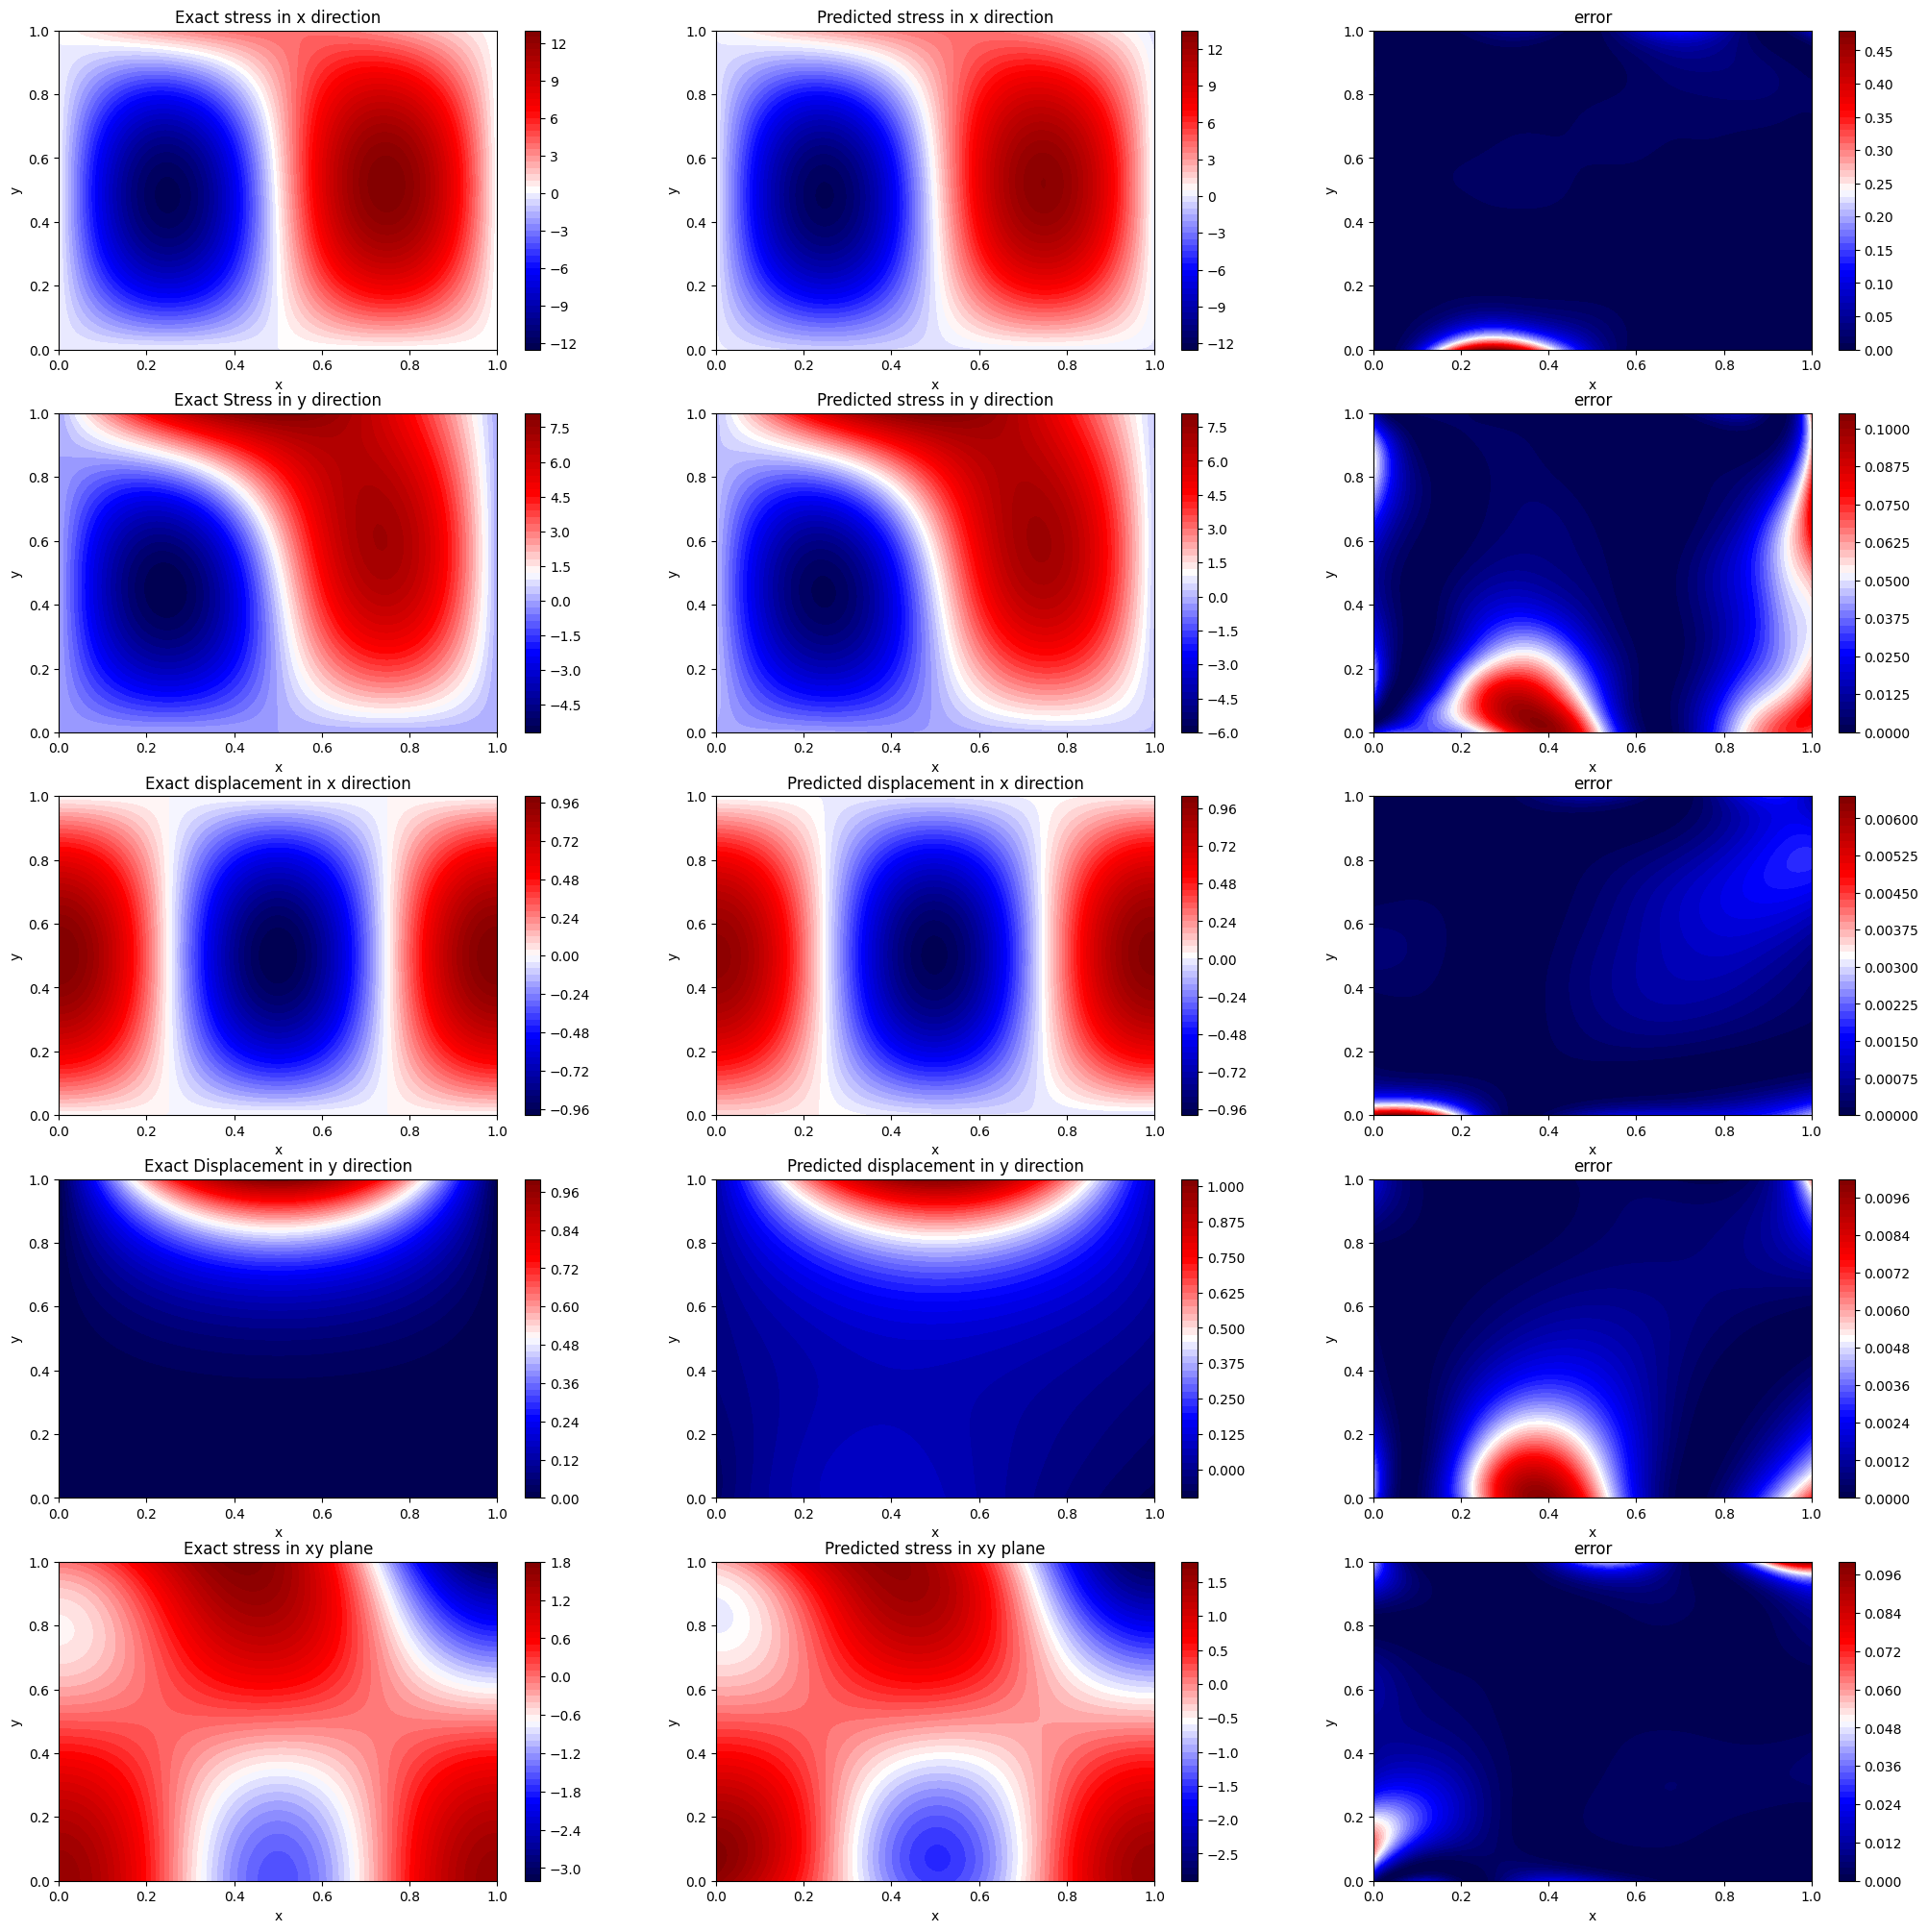

In [21]:
fig = plt.figure(figsize=(25,25),dpi=100)
plt.subplot(5, 3, 1)
plt.contourf(arr_x1,arr_y1, sx, 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title('Exact stress in x direction')

plt.subplot(5, 3, 2)
plt.contourf(arr_x1,arr_y1, arr_sx, 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted stress in x direction")

plt.subplot(5, 3, 3)
plt.contourf(arr_x1,arr_y1, np.square(sx-arr_sx), 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("error")

plt.subplot(5, 3, 4)
plt.contourf(arr_x1,arr_y1, sy, 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact Stress in y direction")

plt.subplot(5, 3, 5)
plt.contourf(arr_x1,arr_y1, arr_sy, 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted stress in y direction")

plt.subplot(5, 3, 6)
plt.contourf(arr_x1,arr_y1, np.square(sy-arr_sy), 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("error")

plt.subplot(5, 3, 7)
plt.contourf(arr_x1,arr_y1, dispX, 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact displacement in x direction")

plt.subplot(5, 3, 8)
plt.contourf(arr_x1,arr_y1, arr_u, 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted displacement in x direction")

plt.subplot(5, 3, 9)
plt.contourf(arr_x1,arr_y1, np.square(dispX-arr_u), 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("error")

plt.subplot(5, 3, 10)
plt.contourf(arr_x1,arr_y1, dispY, 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact Displacement in y direction")

plt.subplot(5, 3, 11)
plt.contourf(arr_x1,arr_y1, arr_v, 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted displacement in y direction")

plt.subplot(5, 3, 12)
plt.contourf(arr_x1,arr_y1, np.square(dispY-arr_v), 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("error")

plt.subplot(5, 3, 13)
plt.contourf(arr_x1,arr_y1, sxy, 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact stress in xy plane")

plt.subplot(5, 3, 14)
plt.contourf(arr_x1,arr_y1, arr_sxy, 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted stress in xy plane")

plt.subplot(5, 3, 15)
plt.contourf(arr_x1,arr_y1, np.square(arr_sxy-sxy), 50, cmap="seismic")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("error")

plt.show()

In [34]:
model.save("model.keras")

In [54]:
model = tf.keras.models.load_model("model.keras")